In [2]:
!pip install tensorflow
!pip install matplotlib
!pip install librosa

In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa

In [4]:
# import zipfile

# with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
#     zip_ref.extractall()

BUILDING DATA LOADING FUNCTION

In [5]:
def load_wav_16k_mono(filename):
    # Agar TF tensor aaya ho to decode karlo
    if isinstance(filename, tf.Tensor):
        filename = filename.numpy().decode("utf-8")

    wav, sample_rate = librosa.load(filename, sr=None, mono=True)

    target_sr = 16000
    if sample_rate != target_sr:
        wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=target_sr)

    return wav.astype("float32")   # numpy return karo (TF dataset handle karega)

PLOTTING THE WAVE

In [6]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [7]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)

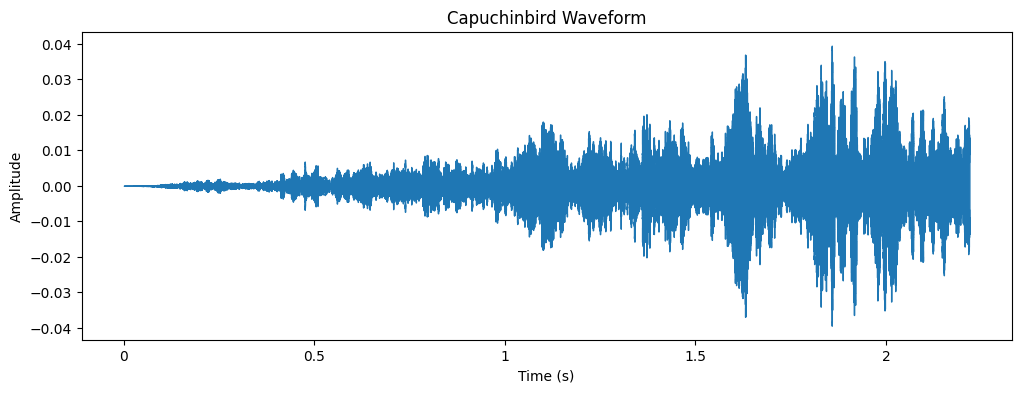

In [12]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(wav)
plt.title("Capuchinbird Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [11]:
wav=load_wav_16k_mono(NOT_CAPUCHIN_FILE)

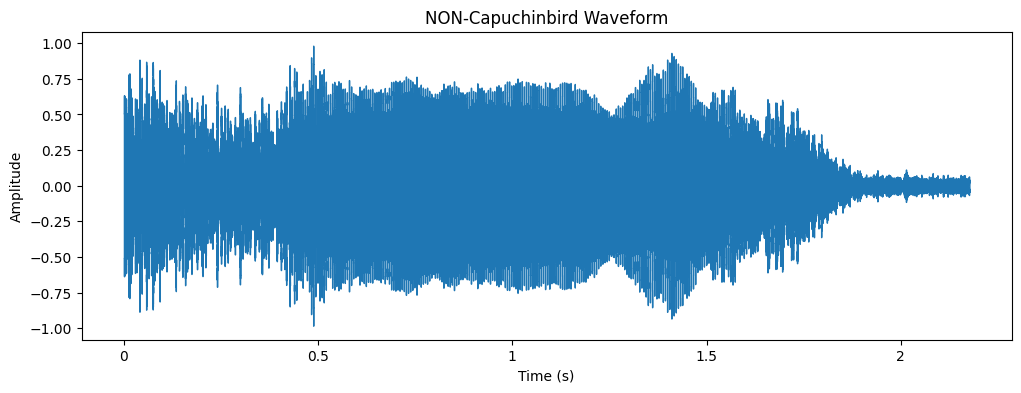

In [10]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(wav)
plt.title("NON-Capuchinbird Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [13]:
max(wav)

np.float32(0.038292542)

In [14]:
min(wav)

np.float32(-0.039393887)

In [15]:
sum(wav)/len(wav)

np.float32(-4.5974854e-08)

CREATING TENSORFLOW DATASET

In [16]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [17]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [18]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC433953-6.wav'

add labels

In [19]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [20]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/crickets-chirping-noise-8.wav',
 np.float32(0.0))

EXPLORATORY DATA ANALYSIS- AVG LENGTH OF THE BIRD'S CALL

In [21]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [22]:
lengths

[48000,
 48000,
 40000,
 64000,
 56000,
 56000,
 56000,
 56000,
 56000,
 64000,
 40000,
 48000,
 72000,
 56000,
 48000,
 48000,
 48000,
 56000,
 48000,
 56000,
 48000,
 64000,
 64000,
 56000,
 56000,
 56000,
 56000,
 56000,
 40000,
 64000,
 48000,
 56000,
 48000,
 56000,
 40000,
 48000,
 72000,
 64000,
 56000,
 56000,
 56000,
 48000,
 48000,
 40000,
 56000,
 56000,
 48000,
 56000,
 48000,
 48000,
 56000,
 48000,
 56000,
 80000,
 56000,
 64000,
 56000,
 64000,
 48000,
 40000,
 56000,
 56000,
 48000,
 56000,
 48000,
 56000,
 64000,
 48000,
 64000,
 64000,
 64000,
 56000,
 56000,
 48000,
 72000,
 64000,
 56000,
 56000,
 56000,
 56000,
 40000,
 56000,
 64000,
 32000,
 56000,
 48000,
 64000,
 56000,
 48000,
 56000,
 48000,
 48000,
 64000,
 48000,
 56000,
 48000,
 64000,
 48000,
 40000,
 56000,
 48000,
 64000,
 56000,
 64000,
 48000,
 56000,
 48000,
 56000,
 48000,
 56000,
 40000,
 32000,
 48000,
 56000,
 64000,
 32000,
 56000,
 64000,
 72000,
 48000,
 56000,
 56000,
 56000,
 56000,
 64000,


CALCULATING MEAN, MEDIAN AND MODE

In [23]:
tf.math.reduce_mean(lengths) #54156/16000= 3.3 sec


<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [24]:
tf.math.reduce_max(lengths) #80000/16000= 5 sec

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [25]:
tf.math.reduce_min(lengths) #32000/16000= 2 sec

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

PREPROCESSING TO CONVERT IT INTO SPECTROGRAM

In [26]:
def preprocess(file_path, label):
    wav, = tf.py_function(
        func=lambda f: (load_wav_16k_mono(f),),
        inp=[file_path],
        Tout=[tf.float32]
    )

    # shape set karo warna graph ko samajh nahi aayega
    wav.set_shape([None])

    # length fix
    wav = wav[:48000]
    zero_padding_length = 48000 - tf.shape(wav)[0]
    wav = tf.concat([tf.zeros([zero_padding_length], dtype=tf.float32), wav], 0)

    # spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    return spectrogram, label

In [27]:
#this spectogram can be seen as a black and white image with no. of channels =1 instead of 3(R,G,B)

VISUALIZING SPECTROGRAM

In [28]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [29]:
spectrogram, label = preprocess(filepath, label)

In [30]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.6261737e+00],
        [1.1722360e+00],
        [3.2035935e-01],
        ...,
        [6.7623623e-05],
        [9.1940739e-05],
        [6.2823296e-05]],

       [[1.5802290e+00],
        [1.1454655e+00],
        [3.2353437e-01],
        ...,
        [6.5846485e-05],
        [1.7721735e-05],
        [1.9073486e-05]],

       [[1.6013236e+00],
        [1.2419765e+00],
        [5.7092732e-01],
        ...,
        [4.2599357e-05],
        [2.0542513e-05],
        [2.6226044e-05]],

       ...,

       [[4.9455225e-02],
        [1.4679259e-01],
        [2.5341383e-01],
        ...,
        [3.5312252e-05],
        [4.7512389e-05],
        [4.4688582e-05]],

       [[1.3377713e-01],
        [2.0102067e-01],
        [2.7970782e-01],
        ...,
        [5.8652768e-05],
        [8.6405735e-06],
        [1.5065074e-05]],

       [[1.6526388e-01],
        [2.2198927e-01],
        [3.0111253e-01],
        ...,
        [7.2806266

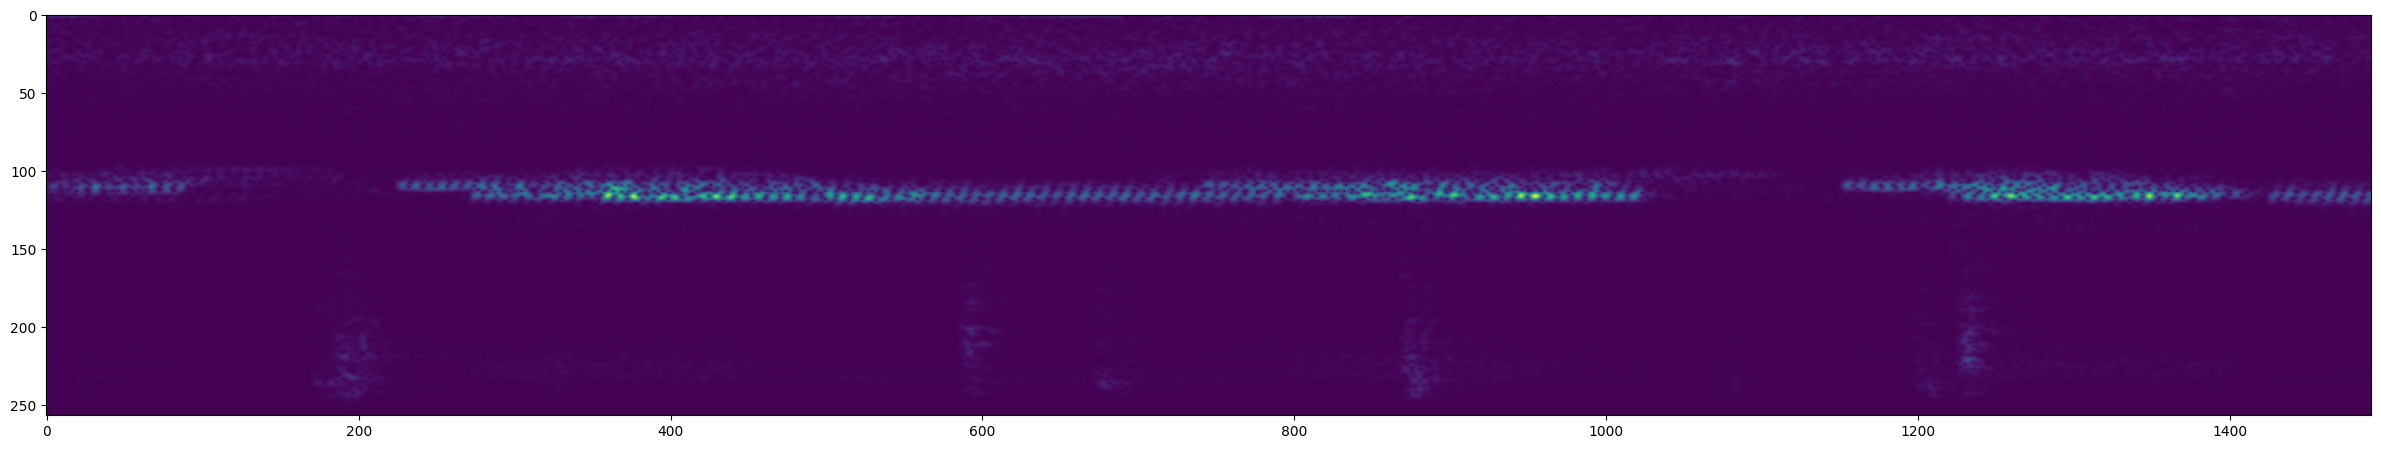

In [31]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

CREATING TRAINING AND TESTING PARTITIONS

In [32]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [33]:
train = data.take(36)
test = data.skip(36).take(15)

In [34]:
samples, labels = train.as_numpy_iterator().next()

In [35]:
labels

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [36]:
samples.shape

(16, 1491, 257, 1)

BUILDING DEEP LEARNING MODEL

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten, Input, MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Input(shape=(1491, 257,1)))
model.add(Conv2D(16, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1491, 257, 16)  │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 745, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 745, 128, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 372, 64, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,137 (35.69 KB)

 Trainable params: 9,137 (35.69 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1491, 257, 16)  │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 745, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 745, 128, 16)   │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 372, 64, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,413 (107.09 KB)

 Trainable params: 9,137 (35.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,276 (71.39 KB)

In [42]:
hist = model.fit(train, epochs=30, validation_data=test)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.1939 - precision: 0.9560 - recall: 0.8035 - val_loss: 0.2130 - val_precision: 1.0000 - val_recall: 0.6316
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.2018 - precision: 0.9693 - recall: 0.7212 - val_loss: 0.1377 - val_precision: 0.9600 - val_recall: 0.8421
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.1737 - precision: 0.9805 - recall: 0.7862 - val_loss: 0.1670 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.1676 - precision: 0.9638 - recall: 0.8321 - val_loss: 0.2531 - val_precision: 1.0000 - val_recall: 0.6032
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.2245 - precision: 0.9202 - recall: 0.7960 - val_loss: 0.1512 - val_precision: 1.0000 - val_recall: 0.8219
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2596 - precision: 0.8452 - recall: 0.7733 - val_loss: 0.1934 - val_precision: 0.9811 - val_recall: 0.77

In [44]:
hist.history

{'loss': [0.19322896003723145,
  0.1815214306116104,
  0.1789611130952835,
  0.17164669930934906,
  0.27703768014907837,
  0.21948784589767456,
  0.1670837551355362,
  0.1569356769323349,
  0.14244918525218964,
  0.19922970235347748,
  0.1862931102514267,
  0.18775059282779694,
  0.15472549200057983,
  0.1240263357758522,
  0.1284351497888565,
  0.16963569819927216,
  0.12932021915912628,
  0.1654866635799408,
  0.1257263869047165,
  0.1132645308971405,
  0.11341837793588638,
  0.14194542169570923,
  0.10522051155567169,
  0.08551868796348572,
  0.1531822234392166,
  0.1310073286294937,
  0.0844293162226677,
  0.09716729819774628,
  0.13238006830215454,
  0.0855163186788559],
 'precision': [0.9674796462059021,
  0.9674796462059021,
  0.9750000238418579,
  0.9682539701461792,
  0.8730158805847168,
  0.9090909361839294,
  0.9626865386962891,
  0.9763779640197754,
  0.9485294222831726,
  0.9051094651222229,
  0.9435483813285828,
  0.9338235259056091,
  0.9750000238418579,
  0.984732806682

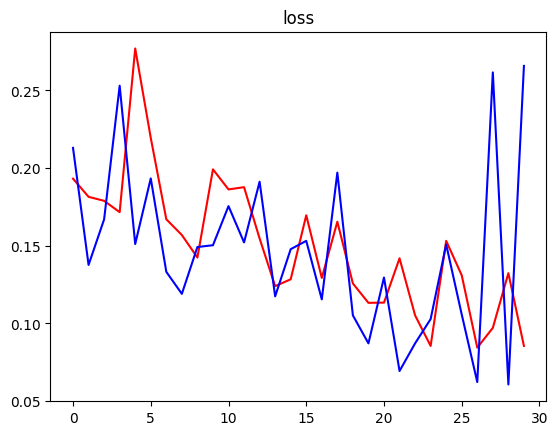

In [45]:
plt.title("loss")
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

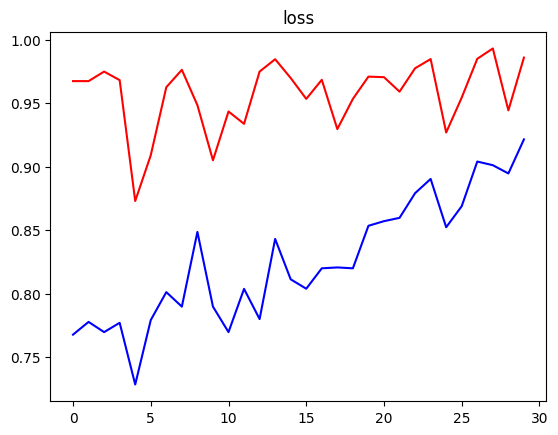

In [46]:
plt.title("loss")
plt.plot(hist.history['precision'],'r')
plt.plot(hist.history['recall'],'b')
plt.show()

In [64]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [65]:
yhat

array([[4.7843922e-02],
       [3.6741019e-04],
       [9.6399784e-01],
       [3.0967283e-05],
       [1.8207924e-02],
       [9.2722875e-01],
       [8.7662185e-05],
       [4.6132356e-02],
       [8.3140410e-05],
       [9.5833772e-01],
       [7.8458957e-02],
       [1.8035066e-04],
       [9.9995720e-01],
       [1.0000000e+00],
       [5.1519535e-05],
       [4.0527027e-02]], dtype=float32)

CONVERTING PROBABILITIES INTO CLASSES

In [66]:

yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [67]:
yhat

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]

In [68]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [69]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [70]:
yhat

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]

In [71]:
y_test.astype(int)

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

BUILDING FOREST PARSING FUNCTIONS

Loading up MP3 files

In [75]:
def load_mp3_16k_mono(filename):
    """ Load an MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio using librosa. """
    # Use librosa to load the audio file
    wav, sample_rate = librosa.load(filename, sr=None, mono=True)

    target_sr = 16000
    if sample_rate != target_sr:
        wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=target_sr)

    # Convert numpy array to TensorFlow tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)

    return wav

In [76]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [78]:
wav = load_mp3_16k_mono(mp3)

getting 48000 sequence strides clip by slicing

In [79]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [80]:
samples, index = audio_slices.as_numpy_iterator().next()

In [83]:
samples.shape

(1, 48000)

In [85]:
len(audio_slices)

60

In [86]:
index

array([-3.8773828e-07], dtype=float32)

FUNCTION TO CONVERT CLIPS INTO WINDOWED SPECTOGRAM

In [87]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

CONVERTING AUDIO INTO CLIPS

In [89]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [90]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


In [94]:
yhat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

GROUP THE CONSECUTIVE PREDICTIONS

In [95]:
from itertools import groupby


In [97]:
yhat=[key for key,group in groupby(yhat)]
calls=tf.math.reduce_sum(yhat).numpy()

In [98]:
calls

np.int32(5)

MAKE PREDICTIONS FOR ALL RECORDINGS

In [99]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [101]:
results

{'recording_44.mp3': array([[0.06156691],
        [0.06170185],
        [0.06202033],
        [0.06172881],
        [0.06127191],
        [0.06059637],
        [0.06193027],
        [0.06188721],
        [0.06250708],
        [0.06155457],
        [0.7059843 ],
        [0.9999969 ],
        [0.0626322 ],
        [0.0607197 ],
        [0.06081577],
        [0.06226921],
        [0.0607665 ],
        [0.06179636],
        [0.06190503],
        [0.06246931],
        [0.06159488],
        [0.06192482],
        [0.06106863],
        [0.06172195],
        [0.06129553],
        [0.06110621],
        [0.06055453],
        [0.06112473],
        [0.06204402],
        [0.06063255],
        [0.060394  ],
        [0.06113075],
        [0.06117165],
        [0.06157176],
        [0.06168735],
        [0.06162203],
        [0.06139352],
        [0.06134257],
        [0.06069525],
        [0.06306212],
        [0.06252559],
        [0.0614368 ],
        [0.06109684],
        [0.0602157 ],
        [0.0

CONVERTING PREDICTIONS INTO CLASSES

In [103]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
class_preds

{'recording_44.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_49.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_11.mp3': [0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_97.mp3': [0,
  0,
  0,
  

FINDING THE NUMBER OF CALLS

In [104]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_44.mp3': np.int32(1),
 'recording_49.mp3': np.int32(0),
 'recording_11.mp3': np.int32(3),
 'recording_97.mp3': np.int32(4),
 'recording_76.mp3': np.int32(0),
 'recording_00.mp3': np.int32(5),
 'recording_98.mp3': np.int32(21),
 'recording_05.mp3': np.int32(0),
 'recording_89.mp3': np.int32(3),
 'recording_63.mp3': np.int32(3),
 'recording_45.mp3': np.int32(3),
 'recording_66.mp3': np.int32(0),
 'recording_51.mp3': np.int32(3),
 'recording_24.mp3': np.int32(0),
 'recording_16.mp3': np.int32(4),
 'recording_09.mp3': np.int32(0),
 'recording_94.mp3': np.int32(3),
 'recording_10.mp3': np.int32(5),
 'recording_77.mp3': np.int32(2),
 'recording_32.mp3': np.int32(2),
 'recording_52.mp3': np.int32(0),
 'recording_62.mp3': np.int32(0),
 'recording_39.mp3': np.int32(1),
 'recording_79.mp3': np.int32(0),
 'recording_01.mp3': np.int32(0),
 'recording_56.mp3': np.int32(4),
 'recording_68.mp3': np.int32(1),
 'recording_21.mp3': np.int32(1),
 'recording_88.mp3': np.int32(0),
 'recording_9

In [105]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [107]:
import pandas as pd


In [108]:
df=pd.read_csv("results.csv")

In [109]:
df

,recording,capuchin_calls
0,recording_44.mp3,1
1,recording_49.mp3,0
2,recording_11.mp3,3
3,recording_97.mp3,4
4,recording_76.mp3,0
...,...,...
95,recording_87.mp3,17
96,recording_31.mp3,1
97,recording_86.mp3,2
98,recording_23.mp3,5


In [110]:
model.save('capuchin_model.h5')